## Import and Load all the necessary packages

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
from google.colab import drive
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.models as models
from sklearn.metrics import roc_curve, auc

##Mount the drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset

In [3]:
def load_verification_pairs(file_path):
    pairs = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            if len(parts) == 3:
                path1, path2, label = parts
                pairs.append((path1, path2, int(label)))
            else:
                print(f"Skipping malformed line: {line.strip()}")
    random.shuffle(pairs)
    return pairs

In [4]:
# paths to the verification files
data_dir = '/content/drive/My Drive/data/data/train_test_split/verification'
verification_pairs_file = os.path.join(data_dir, 'verification_pairs_easy.txt')


# images path
base_image_dir = '/content/drive/My Drive/data/data/image/'
verification_pairs = load_verification_pairs(verification_pairs_file)

In [5]:
#this function is to filter the required number of car markers
def parse_class(image_path_tuple):
    return int(image_path_tuple[0].split('/')[0])

def filter_image_pairs(image_pairs, num_classes=50):

    all_classes = {parse_class(pair) for pair in image_pairs}
    #selected_classes = set(random.sample(all_classes, num_classes))
    selected_classes = set(random.sample(list(all_classes), num_classes))
    filtered_pairs = [
        pair for pair in image_pairs
        if parse_class(pair) in selected_classes
    ]
    return filtered_pairs
filtered_pairs = filter_image_pairs(verification_pairs, num_classes=20)

In [6]:
# this function is for checking the above selected car makers in the dataset
def check_image_paths(pairs, base_image_dir):
    valid_pairs = []
    for img1_path, img2_path, label in pairs:
        full_img1_path = os.path.join(base_image_dir, img1_path)
        full_img2_path = os.path.join(base_image_dir, img2_path)
        if os.path.exists(full_img1_path) and os.path.exists(full_img2_path):
            valid_pairs.append((full_img1_path, full_img2_path, label))
        else:
            pass
    return valid_pairs

valid_pairs = check_image_paths(filtered_pairs, base_image_dir)
print(f"Number of valid pairs: {len(valid_pairs)}")

Number of valid pairs: 821


##Load Image pairs as train and test data

In [7]:
train_pairs, temp_pairs = train_test_split(valid_pairs, test_size=0.3, random_state=42)
val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

print(f"Number of valid training pairs: {len(train_pairs)}")
print(f"Number of valid validation pairs: {len(val_pairs)}")
print(f"Number of valid testing pairs: {len(test_pairs)}")

class SiameseDataset(Dataset):
    def __init__(self, pairs, img_size=(224, 224), transform=None):
        self.pairs = pairs
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, np.array(label, dtype=np.float32)

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Datasets
train_dataset = SiameseDataset(train_pairs, transform=transform)
val_dataset = SiameseDataset(val_pairs, transform=transform)
test_dataset = SiameseDataset(test_pairs, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")
print(f"Number of batches in testing loader: {len(test_loader)}")


Number of valid training pairs: 574
Number of valid validation pairs: 123
Number of valid testing pairs: 124
Number of batches in training loader: 9
Number of batches in validation loader: 2
Number of batches in testing loader: 2


##Find the best mean and std for transform the data

In [8]:
def calculate_mean_std(dataloader):
    mean = 0.
    std = 0.
    n_samples = 0.

    for img1, img2, _ in dataloader:

        images = torch.cat([img1, img2], dim=0)
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_samples += batch_samples

    mean /= n_samples
    std /= n_samples
    return mean, std


In [9]:
mean, std = calculate_mean_std(train_loader)
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4845, 0.4774, 0.4689])
Std: tensor([0.2586, 0.2556, 0.2587])


In [10]:
new_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = SiameseDataset(train_pairs, transform=new_transform)
val_dataset = SiameseDataset(val_pairs, transform=new_transform)
test_dataset = SiameseDataset(test_pairs, transform=new_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

##View image pairs in train data

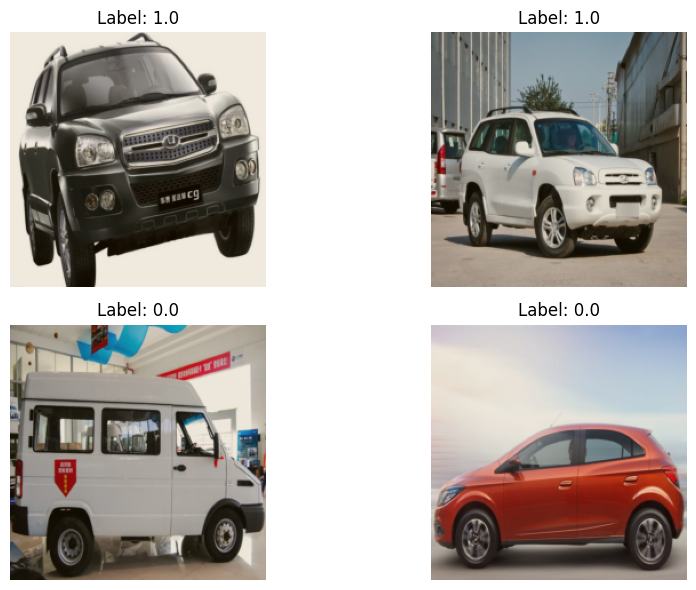

In [11]:
def show_image_pairs(dataset, num_pairs=2):
    plt.figure(figsize=(10, 6))
    for i in range(num_pairs):
        img1, img2, label = dataset[i]

        img1 = img1.permute(1, 2, 0).numpy()
        img2 = img2.permute(1, 2, 0).numpy()


        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img1 = std * img1 + mean
        img2 = std * img2 + mean
        img1 = np.clip(img1, 0, 1)
        img2 = np.clip(img2, 0, 1)

        ax1 = plt.subplot(num_pairs, 2, 2*i + 1)
        ax1.imshow(img1)
        ax1.set_title(f'Label: {label}')
        ax1.axis('off')

        ax2 = plt.subplot(num_pairs, 2, 2*i + 2)
        ax2.imshow(img2)
        ax2.set_title(f'Label: {label}')
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

show_image_pairs(test_dataset, num_pairs=2)


##Model using ResNet architecture

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),


            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
        )

        self._to_linear = None
        self.convs(torch.randn(1, 3, 224, 224))
        self.fc1 = nn.Sequential(
            nn.Linear(self._to_linear, 1024),
            nn.BatchNorm1d(1024),  # Batch normalization layer
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Dropout layer

            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),  # Batch normalization layer
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Dropout layer

            nn.Linear(128,128)
        )

    def convs(self, x):
        x = self.cnn1(x)
        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        return x

    def forward_once(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

model = SiameseNetwork()

##Contrastive Loss

In [13]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 1) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 1))


        return loss_contrastive

In [14]:
class Config():
    training_dir = train_dataset
    testing_dir = test_dataset
    train_batch_size = 32
    train_number_epochs = 20

##Train

In [15]:
import torch
print(torch.cuda.is_available())


True


In [16]:
#  Siamese Network
net = SiameseNetwork().cuda()
#  Loss Function
criterion = ContrastiveLoss()
#  Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)

In [19]:
def train():
    counter = []
    loss_history = []
    iteration_number= 0

    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_loader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net

In [17]:
def train():
    counter = []
    loss_history = []
    val_loss_history = []
    iteration_number = 0

    for epoch in range(Config.train_number_epochs):
        net.train()
        for i, data in enumerate(train_loader, 0):
            img0, img1, label = data
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()

            if i % 50 == 0:
                print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
                iteration_number += 10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

        # Validation step
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                img0, img1, label = data
                img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

                output1, output2 = net(img0, img1)
                loss_contrastive = criterion(output1, output2, label)
                val_loss += loss_contrastive.item()

        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        print("Epoch number {}\n Validation loss {}\n".format(epoch, val_loss))

    return net, counter, loss_history, val_loss_history


In [45]:
def train():
    counter = []
    loss_history = []
    val_loss_history = []
    iteration_number = 0

    for epoch in range(Config.train_number_epochs):
        net.train()
        for i, data in enumerate(train_loader, 0):
            img0, img1, label = data
            img0, img1, label = img0, img1, label

            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()

            if i % 50 == 0:
                print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
                iteration_number += 10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

        # Validation step
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                img0, img1, label = data
                img0, img1, label = img0, img1, label

                output1, output2 = net(img0, img1)
                loss_contrastive = criterion(output1, output2, label)
                val_loss += loss_contrastive.item()

        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        print("Epoch number {}\n Validation loss {}\n".format(epoch, val_loss))

    return net, counter, loss_history, val_loss_history


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
net, counter, loss_history, val_loss_history = train()
torch.save(model.state_dict(), '/content/drive/My Drive/siamese_model.pth')
print("Model Saved Successfully")

Epoch number 0
 Current loss 2.4872312545776367

Epoch number 0
 Validation loss 1.2884893119335175

Epoch number 1
 Current loss 0.6473147869110107

Epoch number 1
 Validation loss 1.0313767343759537

Epoch number 2
 Current loss 1.2704682350158691

Epoch number 2
 Validation loss 1.08411905169487

Epoch number 3
 Current loss 0.7922201156616211

Epoch number 3
 Validation loss 1.0841289162635803

Epoch number 4
 Current loss 0.9971730709075928

Epoch number 4
 Validation loss 1.160211592912674

Epoch number 5
 Current loss 0.684443473815918

Epoch number 5
 Validation loss 1.1285093426704407

Epoch number 6
 Current loss 0.6882887482643127

Epoch number 6
 Validation loss 1.0518678575754166

Epoch number 7
 Current loss 0.9981732368469238

Epoch number 7
 Validation loss 1.1600253582000732

Epoch number 8
 Current loss 0.7372316122055054

Epoch number 8
 Validation loss 1.0885321497917175

Epoch number 9
 Current loss 0.6948407292366028

Epoch number 9
 Validation loss 1.052934333682

In [26]:
len(val_loss_history)

20

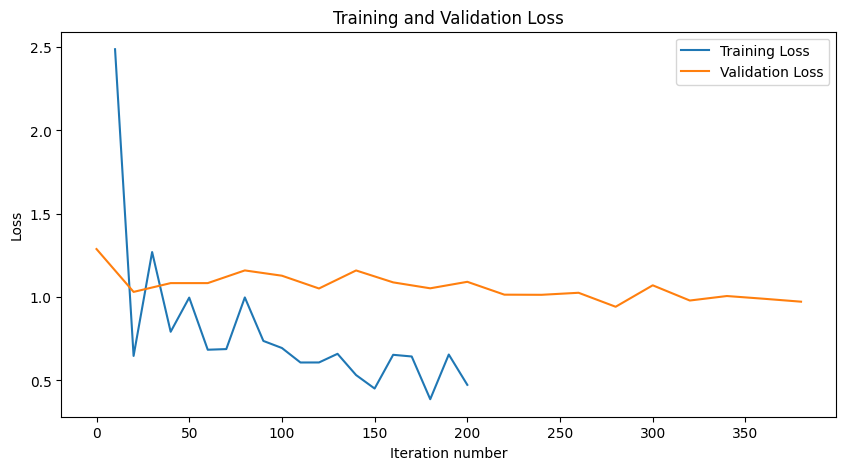

In [21]:

# Plotting the loss history
plt.figure(figsize=(10, 5))
plt.plot(counter, loss_history, label='Training Loss')
plt.plot([i * len(counter) for i in range(len(val_loss_history))], val_loss_history, label='Validation Loss')
plt.xlabel('Iteration number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


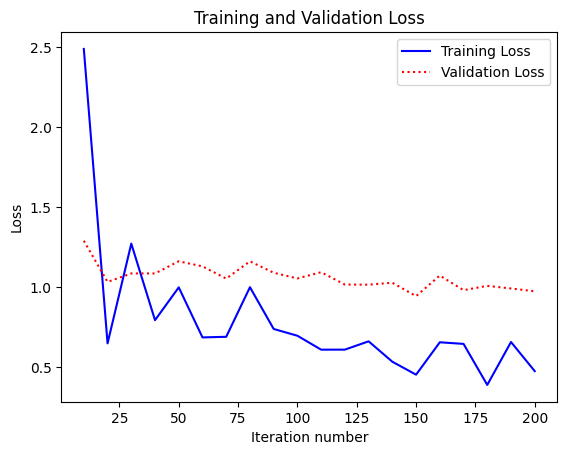

In [27]:
plt.plot(counter, loss_history, label='Training Loss', color='blue')
plt.plot(counter, val_loss_history, label='Validation Loss', color='red', linestyle='dotted')

# Adding labels and title
plt.xlabel('Iteration number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

##Load the model

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("/content/drive/My Drive/siamese_model.pth"))

<All keys matched successfully>

##View image pairs with dissimilarity value

In [29]:
def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


def view(model, test_loader, num_pairs=10):
    model.eval()
    with torch.no_grad():
        pair_count = 0
        for i, (img1, img2, label) in enumerate(test_loader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            euclidean_distances = F.pairwise_distance(output1, output2)

            for j in range(len(euclidean_distances)):
                concatenated = torch.cat((img1[j].unsqueeze(0), img2[j].unsqueeze(0)), 0)
                imshow(torchvision.utils.make_grid(concatenated.cpu()),
                       f'Dissimilarity: {euclidean_distances[j].item():.2f} Label: {label[j].item()}')
                pair_count += 1
                if pair_count >= num_pairs:
                    return

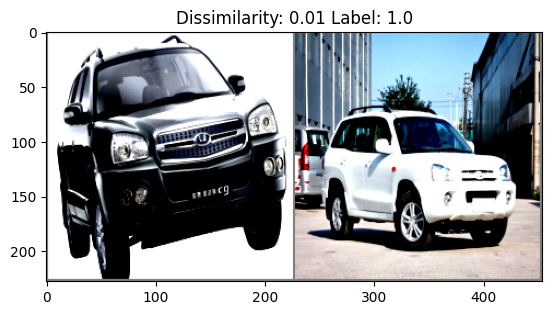

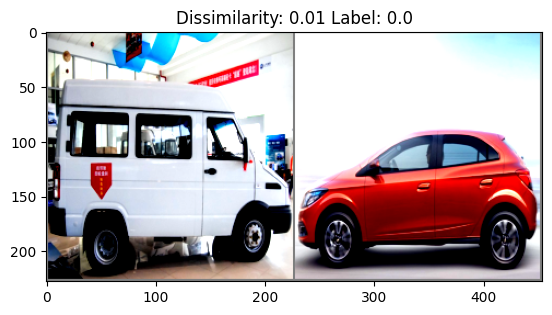

In [35]:
view(model, test_loader,num_pairs=2)

##Model Evaluate

In [36]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            euclidean_distance = F.pairwise_distance(output1, output2)
            predictions = (euclidean_distance < 1).float()  # 1.0 as a threshold
            correct += (predictions == label).sum().item()
            total += label.size(0)
    accuracy = correct / total
    return accuracy

##Evaluate the model

In [37]:
# Evaluate the model
accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 70.16%
